# Selecting data & finding the most common complaint type

## Install

In [1]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# !pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


✅ The installed version of syft==0.8.1b2 matches the requirement >=0.8.1b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-2", port=8083, reset=True)

Starting pandas-test-domain-2 server on 0.0.0.0:8083
SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/b4366a5a11e444ba935b96ec3457379a.sqlite



# Data Owner: Upload data

In [4]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [5]:
from syft.serde.mock import CachedFaker
from random import randint
from syft.util.util import PANDAS_DATA
from syft.service.project.project import Project
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [7]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(sy.autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [8]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

## Create Mock data

Let's create the mock data for the complaint dataset.

In [9]:
fake = CachedFaker()

In [10]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [11]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [12]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [13]:
mock = pd.DataFrame(data=mock_data)

In [14]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,650701,2004-08-20 04:09:51,1970-05-15 12:27:13,DOHMH,James Castro,Illegal Parking,Broken Glass,Pool,52582,"5722 Fisher Junctions\nThomasland, ME 34898",Keith Mills,Collins Brook,Kristy Walk,Aaron Plains,West Shore,PLACENAME,South Stacey,PROSPECT PARK,DSNY Garage,Open,2006-12-04 21:42:04,1978-09-25 20:36:29,04 BRONX,QUEENS,901356,538253,Kent Edwards,MANHATTAN,Jeanette Thompson,B100,Region 1,11X175,7189673542,"84688 Brown Isle\nMarkfort, NY 66985",COLLEGE POINT,Unspecified,98232,N,NaN,Car Service,MANHATTAN,La Guardia Airport,Williamsburg Br,Northbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Grant Ave Field,NaN,Whitehall Terminal (Manhattan),167.923322,57.114300,"(176.898594, -153.449263)"
1,736287,2012-06-20 15:10:57,2019-12-21 04:58:01,DOHMH,Abigail Phillips,Illegal Parking,Branches Damaged,1-3 Family Mixed Use Building,31098,"115 Mahoney Haven\nSheilaview, OK 21842",James Duffy,Jackson Shoal,Newman Lodge,Daniel Wall,Rebecca Ports,NaN,New Mary,FERRY TERMINAL,DSNY Garage,Assigned,1992-08-06 20:24:46,2010-02-03 20:19:36,03 BROOKLYN,BROOKLYN,471612,635937,Dale Jackson,QUEENS,Sarah Clark,B080-01,Region 9,18K066,7187712787,"464 Griffin Tunnel\nMorrisstad, OK 51389",ASTORIA,Unspecified,70303,N,NaN,NaN,NaN,JFK Airport,Clearview Expwy,NaN,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Sheepshead Bay #1 Field,NaN,JOSE URBAEZ,-34.650869,123.471942,"(-48.292325, -37.529483)"
2,406807,2009-03-25 20:54:39,2006-12-04 21:42:04,NYPD,Matthew Warren,Noise - Street/Sidewalk,Broken Glass,Address Outside of NYC,86993,"39066 Patrick Forge\nJacksonfort, VT 85055",Evelyn Sanchez,Kristin Mission,Adam Extension,Carroll Valleys,Jeremy Fort,BLOCKFACE,Scottberg,GRAND ARMY PLAZA,Precinct,Assigned,1985-04-20 20:16:45,1993-07-31 07:29:21,Unspecified BROOKLYN,MANHATTAN,803142,164851,James Vance,BROOKLYN,Troy Jones,B111,Region 5,22K139,2122553705,"501 Patricia Crossroad\nHallbury, MS 17065",SPRINGFIELD GARDENS,Unspecified,43166,N,NaN,Car Service,STATEN ISLAND,NaN,Cross Bronx Expwy,Bronx/North Bound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flushing #2 Field,NaN,SHARLETTE SMITH,-164.763521,12.216062,"(163.393240, 149.811328)"
3,707135,1994-01-16 23:46:01,2019-07-21 04:28:49,DOHMH,Chad Moss,Illegal Parking,Broken Glass,Cafeteria - Public School,42212,Unit 1068 Box 1546\nDPO AP 47177,Sarah Perkins,James Brooks,Riley Harbors,Stephanie Rest,Allen Court,ADDRESS,Gonzalesside,METROPOLITAN MUSEUM,NaN,Assigned,2000-01-30 00:31:19,1971-09-22 13:14:33,06 MANHATTAN,STATEN ISLAND,307010,251081,Emma Smith,Unspecified,Michael Greer,B099,Region 6,10X660,7187568400,"411 Mendoza Ridges\nNew Carrie, MI 51641",MIDDLE VILLAGE,NY,04009,Y,NaN,Ambulette / Paratransit,NaN,La Guardia Airport,Westchester Ave Br - Bronx River,Bronx Bound,NaN,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Sheepshead Bay #1 Field,Staten Island Bound,Barberi,122.809506,158.766790,"(49.547844, -65.802164)"
4,351763,1982-03-17 16:01:31,2008-08-29 05:46:05,NYPD,Wendy Torres,'Animal in a Park',Branch or Limb Has Fallen Down,Food Cart Vendor,31989,"4822 Flores Throughway\nSouth Ann, NJ 70431",Emily Tucker,Robert Trace,Thomas Cove,Ryan Spur,Boyd Mews,BLOCKFACE,Antoniomouth,QUEENS COLLEGE,NaN

In [15]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)


  0%|                                                                                                                 | 0/1 [00:00<?, ?it/s]

Uploading: complaints


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## Create data scientist

In [16]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: create syft_function

## Download mock and submit project

### Get mock

In [17]:
guest_domain_client = node.client

In [18]:
# guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [19]:
ds = guest_domain_client.datasets[0]

In [20]:
asset = ds.assets["complaints"]

In [21]:
complaints_pointer = asset.mock

### What's even in it? (the summary)


When you print a large dataframe, it will only show you the first few rows.

If you don't see this, don't panic! The default behavior for large dataframes changed between pandas 0.12 and 0.13. Previous to 0.13 it would show you a summary of the dataframe. This includes all the columns, and how many non-null values there are in each column.

In [22]:
complaints_pointer

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,650701,2004-08-20 04:09:51,1970-05-15 12:27:13,DOHMH,James Castro,Illegal Parking,Broken Glass,Pool,52582,"5722 Fisher Junctions\nThomasland, ME 34898",Keith Mills,Collins Brook,Kristy Walk,Aaron Plains,West Shore,PLACENAME,South Stacey,PROSPECT PARK,DSNY Garage,Open,2006-12-04 21:42:04,1978-09-25 20:36:29,04 BRONX,QUEENS,901356,538253,Kent Edwards,MANHATTAN,Jeanette Thompson,B100,Region 1,11X175,7189673542,"84688 Brown Isle\nMarkfort, NY 66985",COLLEGE POINT,Unspecified,98232,N,NaN,Car Service,MANHATTAN,La Guardia Airport,Williamsburg Br,Northbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Grant Ave Field,None,Whitehall Terminal (Manhattan),167.923322,57.114300,"[176.898594, -153.449263]"
1,736287,2012-06-20 15:10:57,2019-12-21 04:58:01,DOHMH,Abigail Phillips,Illegal Parking,Branches Damaged,1-3 Family Mixed Use Building,31098,"115 Mahoney Haven\nSheilaview, OK 21842",James Duffy,Jackson Shoal,Newman Lodge,Daniel Wall,Rebecca Ports,None,New Mary,FERRY TERMINAL,DSNY Garage,Assigned,1992-08-06 20:24:46,2010-02-03 20:19:36,03 BROOKLYN,BROOKLYN,471612,635937,Dale Jackson,QUEENS,Sarah Clark,B080-01,Region 9,18K066,7187712787,"464 Griffin Tunnel\nMorrisstad, OK 51389",ASTORIA,Unspecified,70303,N,NaN,None,None,JFK Airport,Clearview Expwy,None,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Sheepshead Bay #1 Field,None,JOSE URBAEZ,-34.650869,123.471942,"[-48.292325, -37.529483]"
2,406807,2009-03-25 20:54:39,2006-12-04 21:42:04,NYPD,Matthew Warren,Noise - Street/Sidewalk,Broken Glass,Address Outside of NYC,86993,"39066 Patrick Forge\nJacksonfort, VT 85055",Evelyn Sanchez,Kristin Mission,Adam Extension,Carroll Valleys,Jeremy Fort,BLOCKFACE,Scottberg,GRAND ARMY PLAZA,Precinct,Assigned,1985-04-20 20:16:45,1993-07-31 07:29:21,Unspecified BROOKLYN,MANHATTAN,803142,164851,James Vance,BROOKLYN,Troy Jones,B111,Region 5,22K139,2122553705,"501 Patricia Crossroad\nHallbury, MS 17065",SPRINGFIELD GARDENS,Unspecified,43166,N,NaN,Car Service,STATEN ISLAND,None,Cross Bronx Expwy,Bronx/North Bound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flushing #2 Field,None,SHARLETTE SMITH,-164.763521,12.216062,"[163.393240, 149.811328]"
3,707135,1994-01-16 23:46:01,2019-07-21 04:28:49,DOHMH,Chad Moss,Illegal Parking,Broken Glass,Cafeteria - Public School,42212,Unit 1068 Box 1546\nDPO AP 47177,Sarah Perkins,James Brooks,Riley Harbors,Stephanie Rest,Allen Court,ADDRESS,Gonzalesside,METROPOLITAN MUSEUM,None,Assigned,2000-01-30 00:31:19,1971-09-22 13:14:33,06 MANHATTAN,STATEN ISLAND,307010,251081,Emma Smith,Unspecified,Michael Greer,B099,Region 6,10X660,7187568400,"411 Mendoza Ridges\nNew Carrie, MI 51641",MIDDLE VILLAGE,NY,04009,Y,NaN,Ambulette / Paratransit,None,La Guardia Airport,Westchester Ave Br - Bronx River,Bronx Bound,None,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Sheepshead Bay #1 Field,Staten Island Bound,Barberi,122.809506,158.766790,"[49.547844, -65.802164]"
4,351763,1982-03-17 16:01:31,2008-08-29 05:46:05,NYPD,Wendy Torres,'Animal in a Park',Branch or Limb Has Fallen Down,Food Cart Vendor,31989,"4822 Flores Throughway\nSouth Ann, NJ 70431",Emily Tucker,Robert Trace,Thomas Cove,Ryan Spur,Boyd Mews,BLOCKFACE,Antoniomouth,QUEENS 

### Selecting columns and rows

To select a column, we index with the name of the column, like this:

In [23]:
complaints_pointer['Complaint Type']

```python
TwinPointer(Mock)
```
0                 Illegal Parking
1                 Illegal Parking
2         Noise - Street/Sidewalk
3                 Illegal Parking
4              'Animal in a Park'
                   ...           
111064    Noise - Street/Sidewalk
111065            Illegal Parking
111066    Noise - Street/Sidewalk
111067            Illegal Parking
111068         'Animal in a Park'
Name: Complaint Type, Length: 111069, dtype: object

To get the first 5 rows of a dataframe, we can use a slice: df[:5].

This is a great way to get a sense for what kind of information is in the dataframe -- take a minute to look at the contents and get a feel for this dataset.



In [24]:
complaints_pointer[:5]


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,650701,2004-08-20 04:09:51,1970-05-15 12:27:13,DOHMH,James Castro,Illegal Parking,Broken Glass,Pool,52582,"5722 Fisher Junctions\nThomasland, ME 34898",Keith Mills,Collins Brook,Kristy Walk,Aaron Plains,West Shore,PLACENAME,South Stacey,PROSPECT PARK,DSNY Garage,Open,2006-12-04 21:42:04,1978-09-25 20:36:29,04 BRONX,QUEENS,901356,538253,Kent Edwards,MANHATTAN,Jeanette Thompson,B100,Region 1,11X175,7189673542,"84688 Brown Isle\nMarkfort, NY 66985",COLLEGE POINT,Unspecified,98232,N,NaN,Car Service,MANHATTAN,La Guardia Airport,Williamsburg Br,Northbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Grant Ave Field,None,Whitehall Terminal (Manhattan),167.923322,57.114300,"[176.898594, -153.449263]"
1,736287,2012-06-20 15:10:57,2019-12-21 04:58:01,DOHMH,Abigail Phillips,Illegal Parking,Branches Damaged,1-3 Family Mixed Use Building,31098,"115 Mahoney Haven\nSheilaview, OK 21842",James Duffy,Jackson Shoal,Newman Lodge,Daniel Wall,Rebecca Ports,None,New Mary,FERRY TERMINAL,DSNY Garage,Assigned,1992-08-06 20:24:46,2010-02-03 20:19:36,03 BROOKLYN,BROOKLYN,471612,635937,Dale Jackson,QUEENS,Sarah Clark,B080-01,Region 9,18K066,7187712787,"464 Griffin Tunnel\nMorrisstad, OK 51389",ASTORIA,Unspecified,70303,N,NaN,None,None,JFK Airport,Clearview Expwy,None,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Sheepshead Bay #1 Field,None,JOSE URBAEZ,-34.650869,123.471942,"[-48.292325, -37.529483]"
2,406807,2009-03-25 20:54:39,2006-12-04 21:42:04,NYPD,Matthew Warren,Noise - Street/Sidewalk,Broken Glass,Address Outside of NYC,86993,"39066 Patrick Forge\nJacksonfort, VT 85055",Evelyn Sanchez,Kristin Mission,Adam Extension,Carroll Valleys,Jeremy Fort,BLOCKFACE,Scottberg,GRAND ARMY PLAZA,Precinct,Assigned,1985-04-20 20:16:45,1993-07-31 07:29:21,Unspecified BROOKLYN,MANHATTAN,803142,164851,James Vance,BROOKLYN,Troy Jones,B111,Region 5,22K139,2122553705,"501 Patricia Crossroad\nHallbury, MS 17065",SPRINGFIELD GARDENS,Unspecified,43166,N,NaN,Car Service,STATEN ISLAND,None,Cross Bronx Expwy,Bronx/North Bound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flushing #2 Field,None,SHARLETTE SMITH,-164.763521,12.216062,"[163.393240, 149.811328]"
3,707135,1994-01-16 23:46:01,2019-07-21 04:28:49,DOHMH,Chad Moss,Illegal Parking,Broken Glass,Cafeteria - Public School,42212,Unit 1068 Box 1546\nDPO AP 47177,Sarah Perkins,James Brooks,Riley Harbors,Stephanie Rest,Allen Court,ADDRESS,Gonzalesside,METROPOLITAN MUSEUM,None,Assigned,2000-01-30 00:31:19,1971-09-22 13:14:33,06 MANHATTAN,STATEN ISLAND,307010,251081,Emma Smith,Unspecified,Michael Greer,B099,Region 6,10X660,7187568400,"411 Mendoza Ridges\nNew Carrie, MI 51641",MIDDLE VILLAGE,NY,04009,Y,NaN,Ambulette / Paratransit,None,La Guardia Airport,Westchester Ave Br - Bronx River,Bronx Bound,None,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Sheepshead Bay #1 Field,Staten Island Bound,Barberi,122.809506,158.766790,"[49.547844, -65.802164]"
4,351763,1982-03-17 16:01:31,2008-08-29 05:46:05,NYPD,Wendy Torres,'Animal in a Park',Branch or Limb Has Fallen Down,Food Cart Vendor,31989,"4822 Flores Throughway\nSouth Ann, NJ 70431",Emily Tucker,Robert Trace,Thomas Cove,Ryan Spur,Boyd Mews,BLOCKFACE,Antoniomouth,QUEENS 

We can combine these to get the first 5 rows of a column:

In [25]:
complaints_pointer['Complaint Type'][:5]

```python
TwinPointer(Mock)
```
0            Illegal Parking
1            Illegal Parking
2    Noise - Street/Sidewalk
3            Illegal Parking
4         'Animal in a Park'
Name: Complaint Type, dtype: object

and it doesn't matter which direction we do it in:

In [27]:
complaints_pointer[:5]['Complaint Type']

```python
TwinPointer(Mock)
```
0            Illegal Parking
1            Illegal Parking
2    Noise - Street/Sidewalk
3            Illegal Parking
4         'Animal in a Park'
Name: Complaint Type, dtype: object

### Selecting multiple columns

What if we just want to know the complaint type and the borough, but not the rest of the information? Pandas makes it really easy to select a subset of the columns: just index with list of columns you want.

In [30]:
complaints_pointer[['Complaint Type', 'Borough']]

,Complaint Type,Borough
0,Illegal Parking,QUEENS
1,Illegal Parking,BROOKLYN
2,Noise - Street/Sidewalk,MANHATTAN
3,Illegal Parking,STATEN ISLAND
4,'Animal in a Park',Unspecified
...,...,...
111064,Noise - Street/Sidewalk,Unspecified
111065,Illegal Parking,BRONX
111066,Noise - Street/Sidewalk,Unspecified
111067,Illegal Parking,BROOKLYN


That showed us a summary, and then we can look at the first 10 rows:



In [31]:
complaints_pointer[['Complaint Type', 'Borough']][:10]

,Complaint Type,Borough
0,Illegal Parking,QUEENS
1,Illegal Parking,BROOKLYN
2,Noise - Street/Sidewalk,MANHATTAN
3,Illegal Parking,STATEN ISLAND
4,'Animal in a Park',Unspecified
5,Noise - Street/Sidewalk,MANHATTAN
6,'Animal in a Park',Unspecified
7,Illegal Parking,STATEN ISLAND
8,'Animal in a Park',BRONX
9,'Animal in a Park',STATEN ISLAND


### What's the most common complaint type?

This is a really easy question to answer! There's a .value_counts() method that we can use:

In [32]:
complaints_pointer['Complaint Type'].value_counts()

```python
TwinPointer(Mock)
```
'Animal in a Park'         37250
Noise - Street/Sidewalk    36922
Illegal Parking            36897
Name: Complaint Type, dtype: int64

If we just wanted the top 10 most common complaints, we can do this:

In [33]:
complaint_counts_pointer = complaints_pointer['Complaint Type'].value_counts()
complaint_counts_pointer[:10]

```python
TwinPointer(Mock)
```
'Animal in a Park'         37250
Noise - Street/Sidewalk    36922
Illegal Parking            36897
Name: Complaint Type, dtype: int64

```python
Pointer
```
<AxesSubplot: >

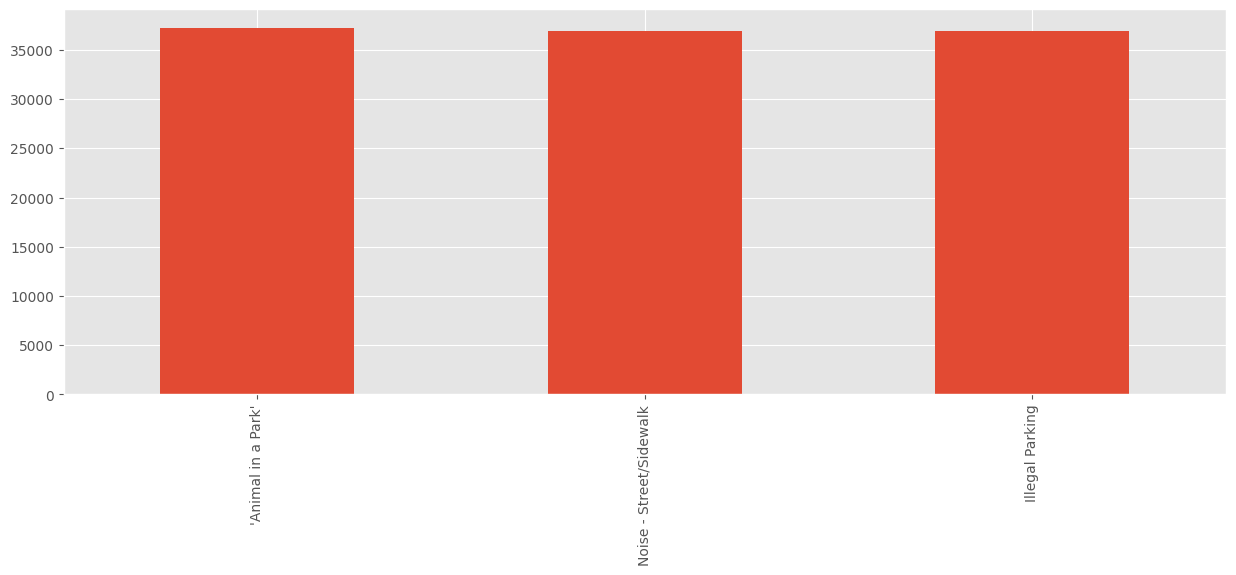

In [34]:
complaint_counts_pointer[:10].plot(kind='bar')

## Request real result

In [35]:
complaint_counts_pointer.request(guest_client)

```python
class Request:
  id: str = e5f8a3233bfb46a1ae4f803727d68865
  requesting_user_verify_key: str = 48b3ed12290fa96b6b60d2fc0da865d399f322aba0fc3ac473584f6b5449cdf0
  approving_user_verify_key: str = None
  request_time: str = 2023-05-17 12:37:38
  approval_time: str = None
  status: str = RequestStatus.PENDING
  node_uid: str = b4366a5a11e444ba935b96ec3457379a
  request_hash: str = "0a09a7c4d214fd10fd76b4d709941f744c2246c15a4fa6a99a73b9565e4aab4a"
  changes: str = [syft.service.request.request.ActionStoreChange]

```

# Data owner: accept request

In [37]:
domain_client = node.client.login(email="info@openmined.org", password="changethis")
domain_client.api.services.request[0].approve()

<class 'syft.service.response.SyftSuccess'>: Request e5f8a3233bfb46a1ae4f803727d68865 changes applied

# Data scientist: fetch result

In [38]:
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [39]:
real_result = complaint_counts_pointer.get_from(guest_client)

<AxesSubplot: >

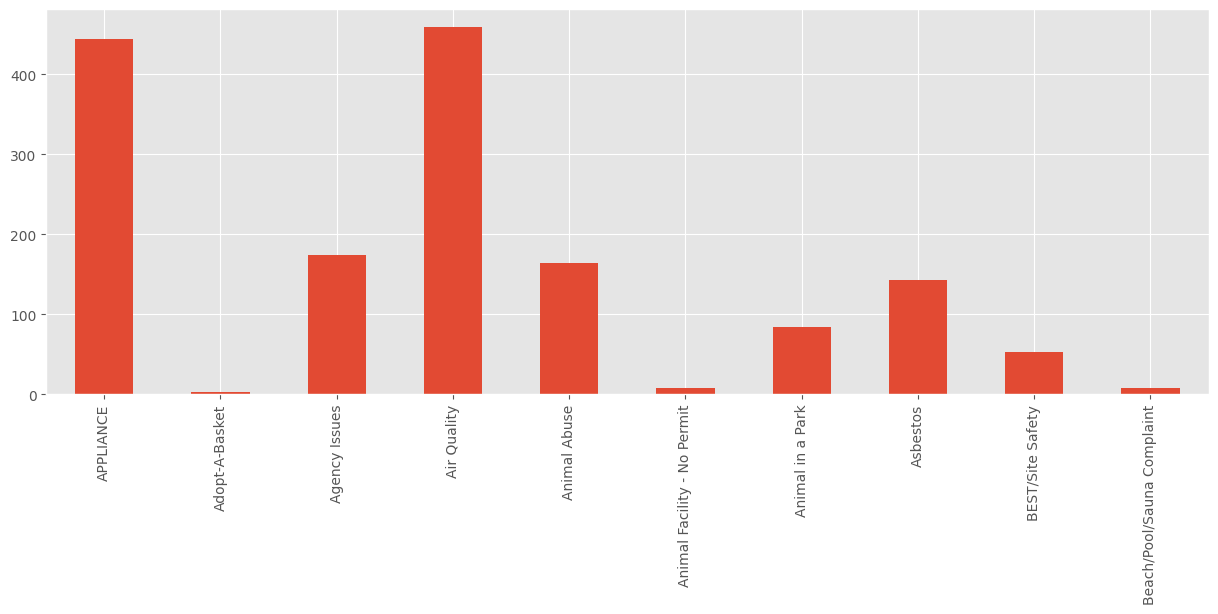

In [42]:
real_result[:10].plot(kind="bar")